In [1]:
import math
import numpy as np
import scipy.sparse
import sys
import os
np.random.seed(0)
np.set_printoptions(threshold=sys.maxsize)

current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
parent = os.path.dirname(parent)
parent = os.path.dirname(parent)


sys.path.append(parent)
import benchmark
import tsp_qubo
import plotter    

In [2]:
class Parameters():
    def __init__(self, mutation_rate, n_individuals, n_generations, selection_pressure, relative_turnament_size):
        self.mutation_rate = mutation_rate
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.selection_pressure = selection_pressure,
        self.relative_turnament_size = relative_turnament_size

In [3]:
class Data():
    fitness = 0
    value = 1
    def __init__(self, individual):
        self.evolution = np.array([individual], dtype=object)
        self.all_time_fittest = individual.copy()

    def add_individual(self, individual):
        self.evolution = np.vstack([self.evolution, individual])
        if self.all_time_fittest[self.fitness] > individual[self.fitness]:
            self.all_time_fittest = individual.copy()

    def get_evolution(self):
        return self.evolution
    
    def get_fitness_evolution(self):
        return self.evolution[:, self.fitness]
    
    def get_individual_evolution(self):
        return self.evolution[:, self.value]
    
    def get_solution(self):
        return self.all_time_fittest

In [4]:
class Qhea():
    fitness = 0 # variable used to index individual for fitness
    value = 1 # variable used to index individual for value, eg. chromosome
    def __init__(self, qubo, parameters):
        '''
        :param qubo: qubo matrix  to optimize (minimize)
        :param parameters: Parameter oject with params to execute the algorithm
        '''
        self.qubo = qubo # save qubo
        self.sparse = scipy.sparse.coo_array(qubo)
        self.n_vars = len(qubo) # n_vars is the chromosome size, 2 ** n_vars is the solution space
        self.n_individuals = parameters.n_individuals # size of the population
        self.n_generations = parameters.n_generations # number of generations 
        self.mutation_rate = parameters.mutation_rate # mutation probabilty per gene
        self.k_competitioners = int(parameters.relative_turnament_size * self.n_individuals)
        self.population, self.crossover_sequence, self.data = self.init() # init data
        
    def init(self):
        population = np.array([[0, np.random.randint(0, 2, self.n_vars)] for j in range(self.n_individuals)],
                      dtype=object) # init population
        
        for ind in range(self.n_individuals):
            population[ind][self.fitness] = self.cost_function(population[ind][self.value]) # initial fitness to population
        
        population = population[population[:, self.fitness].argsort()] # sort ascending by fitness
        
        crossover_sequence = np.array([0^(int(i / int(self.n_vars / 2)) > 0) for i in range(self.n_vars)]) # calculate crossover sequence
        data = Data(population[0]) # init data object to collect data from algorithm

        return population, crossover_sequence, data
    
    def cost_function(self, val):
        return val @ self.sparse @ val # calculate fitness

    def optimize(self):
        for gen in range(self.n_generations): # evolution loop
            for ind in range(int(self.n_individuals / 2)): # iterating over the better half of individuals
                
                # mutation sequence is an array of [0,1], with a probabilty of mutation_rate for each index to be 1
                mutation_sequence_1 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 1
                mutation_sequence_2 = np.random.random(self.n_vars) < self.mutation_rate # mutation sequence 2

                # select individual 1 to be replaced from worse half of population (first child)
                
                compititioners = np.array([])
                index_1 = np.random.randint(0,len(self.population))
                index_2 = np.random.randint(0,len(self.population))

                parent_1 = self.population[index_1]
                parent_2 = self.population[index_2]
                compititioners = np.append(compititioners, [index_1, index_2])

                for i in range(self.k_competitioners):
                    challenger_index = np.random.randint(0,len(self.population))

                    if len(np.where(compititioners == challenger_index)[0]) == 0:
                        challenger = self.population[challenger_index]
                        compititioners = np.append(compititioners, [challenger_index])
                        if  parent_1[self.fitness] > challenger[self.fitness]:
                            parent_1 = challenger
                    else:
                        i-= 1

                for i in range(self.k_competitioners):
                    challenger_index = np.random.randint(0,len(self.population))

                    if len(np.where(compititioners == challenger_index)[0]) == 0:
                        challenger = self.population[challenger_index]
                        compititioners = np.append(compititioners, [challenger_index])
                        if  parent_2[self.fitness] > challenger[self.fitness]:
                            parent_2 = challenger
                    else:
                        i-= 1
                


                offspring_1_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parent_1[self.value], self.crossover_sequence), # getting the genes from first parent (where crossover is 1)
                    np.logical_and(parent_2[self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars))) # getting the genes from second parent (where crossover is 0)
                ),
                mutation_sequence_1
                )
               

                # select individual 2 to be replaced from worse half of population (second child)
                offspring_2_chromosome = np.logical_xor(
                np.add(
                    np.logical_and(parent_2[self.value], self.crossover_sequence), # getting the genes from second parent (where crossover is 1)
                    np.logical_and(parent_1[self.value], np.logical_xor(self.crossover_sequence, np.ones(self.n_vars)))  # getting the genes from first parent (where crossover is 0)
                ), mutation_sequence_2)
                # note how the order of parents changed for individual 2
                self.population = np.vstack([self.population, np.array([0, offspring_1_chromosome], dtype=object)], dtype=object)
                self.population = np.vstack([self.population, np.array([0, offspring_2_chromosome], dtype=object)], dtype=object)
            # apply fitness to every new individual
            for ind in range(self.n_individuals, len(self.population)):
                self.population[ind][self.fitness] = self.cost_function(self.population[ind][self.value])
            
            # sort ascending by fitness
            self.population = self.population[self.population[:, self.fitness].argsort()]
            self.population = self.population[:self.n_individuals]

            # add fittest individual to data set
            self.data.add_individual(self.population[0])
        
        # when done, return data set
        return self.data

In [5]:
tsp = benchmark.distances.get_tsp(benchmark.distances.get_tsp_names()[0]).distances
n_nodes = len(tsp)
penalty = 100
constraint_matrix = np.zeros((n_nodes ** 2, n_nodes ** 2))
constraint_matrix = tsp_qubo.generate.apply_penalties(constraint_matrix, penalty)

amp = np.zeros((n_nodes, n_nodes))
for i in range(len(amp)):
    amp[i][(i + 1) % n_nodes] = 1
objective = np.kron(amp, tsp)
qubo = objective + constraint_matrix

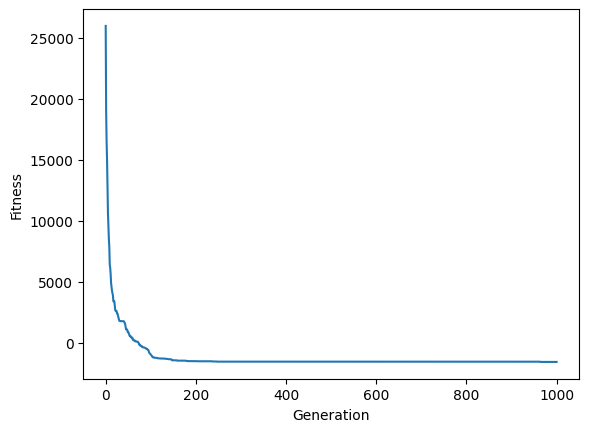

In [6]:
parameters = Parameters(
    mutation_rate=0.05,
    n_individuals=100,
    n_generations=1000,
    selection_pressure=0, # irrelevant in this execution,
    relative_turnament_size=0.2
)

evolutions = np.array([0 for i in range(parameters.n_generations+1)], dtype=object)

for i in range(5):
    solver = Qhea(qubo=qubo,parameters=parameters)
    result = solver.optimize()
    evolution = result.get_fitness_evolution()
    evolutions = np.add(evolutions, evolution)

evolutions = evolutions / 5
plotter.plot_evolution(evolutions, "selection_tournament_k=20%", 3)


## Experiment Description
The algorithm was tested with a medium mutation rate of 0.05% probability and selection fittest / elitist.

## Result
<img src="files/selection_fittest_ease.png">
